In [1]:
# Last updated: May 14, 2024

## Overview

- Learn how to (lazy) load catalogs
- Learn how to use those catalogs and perform crossmatching with existing `LSDB` catalogs
- Save the results

In [2]:
import numpy as np
import pandas as pd
import astropy.units as u
import os

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams

%matplotlib inline
%config InlineBackend.figure_format = "retina"
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
mpl.rcParams['axes.linewidth'] = 2

In [3]:
import lsdb
from lsdb.core.search import BoxSearch, ConeSearch, PolygonSearch
from hipscat.inspection import plot_pixels
from hipscat.io.file_io import read_parquet_metadata

'Version of lsdb is %s' % lsdb.__version__

'Version of lsdb is 0.2.3.dev13+g006a60c'

In [4]:
# Gaia
gaia_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/gaia_dr3/gaia"

# ZTF
ztf_object_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_dr14/"
ztf_source_path = "https://epyc.astro.washington.edu/~lincc-frameworks/hipscat_surveys/ztf/ztf_zource/"

In [5]:
%%time

# Load lite (coarse) version of Gaia DR3 (it has data from all the HEALPix intersecting with the cone)
cone_search = ConeSearch(ra=-60, dec=20.5, radius_arcsec=1*3600)
gaia_lite = lsdb.read_hipscat(gaia_path, columns=["ra", "dec"], search_filter=cone_search)

# Load Gaia data for the same cone (keeps only data inside the cone)
gaia = lsdb.read_hipscat(gaia_path).cone_search(ra=-60, dec=20.5, radius_arcsec=1*3600, fine=True)

CPU times: user 1.22 s, sys: 246 ms, total: 1.47 s
Wall time: 1.52 s


In [6]:
list(read_parquet_metadata(os.path.join(gaia_path, "_common_metadata")).schema)[:2]

[<ParquetColumnSchema>
   name: _hipscat_index
   path: _hipscat_index
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: Int(bitWidth=64, isSigned=false)
   converted_type (legacy): UINT_64,
 <ParquetColumnSchema>
   name: solution_id
   path: solution_id
   max_definition_level: 1
   max_repetition_level: 0
   physical_type: INT64
   logical_type: None
   converted_type (legacy): NONE]

In [7]:
gaia_lite_computed = gaia_lite.compute()

In [8]:
gaia_lite

,ra,dec
npartitions=4,,
3645663898356416512,double[pyarrow],double[pyarrow]
3646789798263259136,...,...
3652700772774182912,...,...
3653545197704314880,...,...
18446744073709551615,...,...


In [9]:
gaia_lite_computed

,ra,dec
_hipscat_index,,
3645663899514044416,299.533159,18.211760
3645663900969467904,299.530223,18.212685
3645663901456007168,299.529506,18.212921
3645663901607002112,299.531427,18.212798
3645663901678305280,299.531440,18.212959
...,...,...
3654671088115253248,299.533488,23.313408
3654671088761176064,299.533875,23.314336
3654671089591648256,299.527580,23.311197


In [10]:
%%time
ztf_object = lsdb.read_hipscat(ztf_object_path, columns=["ra", "dec"]) # ZTF Object
ztf_source = lsdb.read_hipscat(ztf_source_path, columns=["ra", "dec"]) # ZTF Source

CPU times: user 2 s, sys: 178 ms, total: 2.18 s
Wall time: 2.2 s


In [11]:
ztf_object

,ra,dec
npartitions=2352,,
0,double[pyarrow],double[pyarrow]
18014398509481984,...,...
...,...,...
13830554455654793216,...,...
18446744073709551615,...,...


In [12]:
ztf_source

,ra,dec
npartitions=41679,,
0,double[pyarrow],double[pyarrow]
4503599627370496,...,...
...,...,...
13833932155375321088,...,...
18446744073709551615,...,...


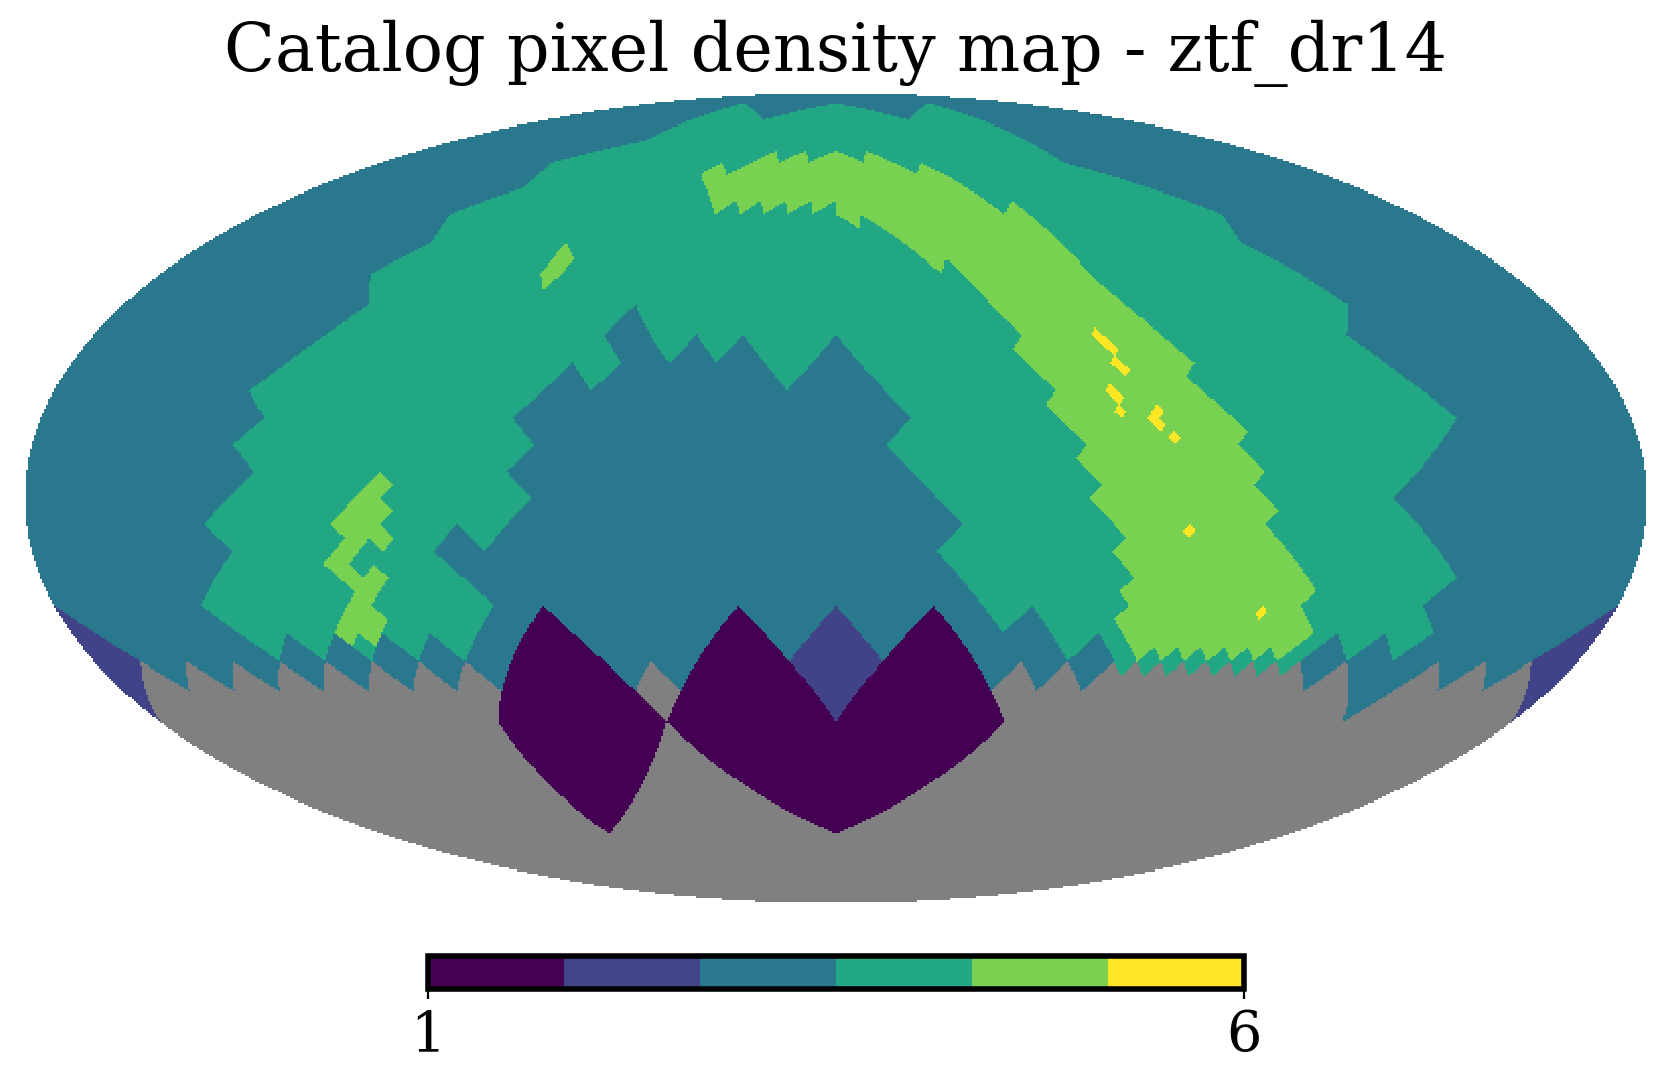

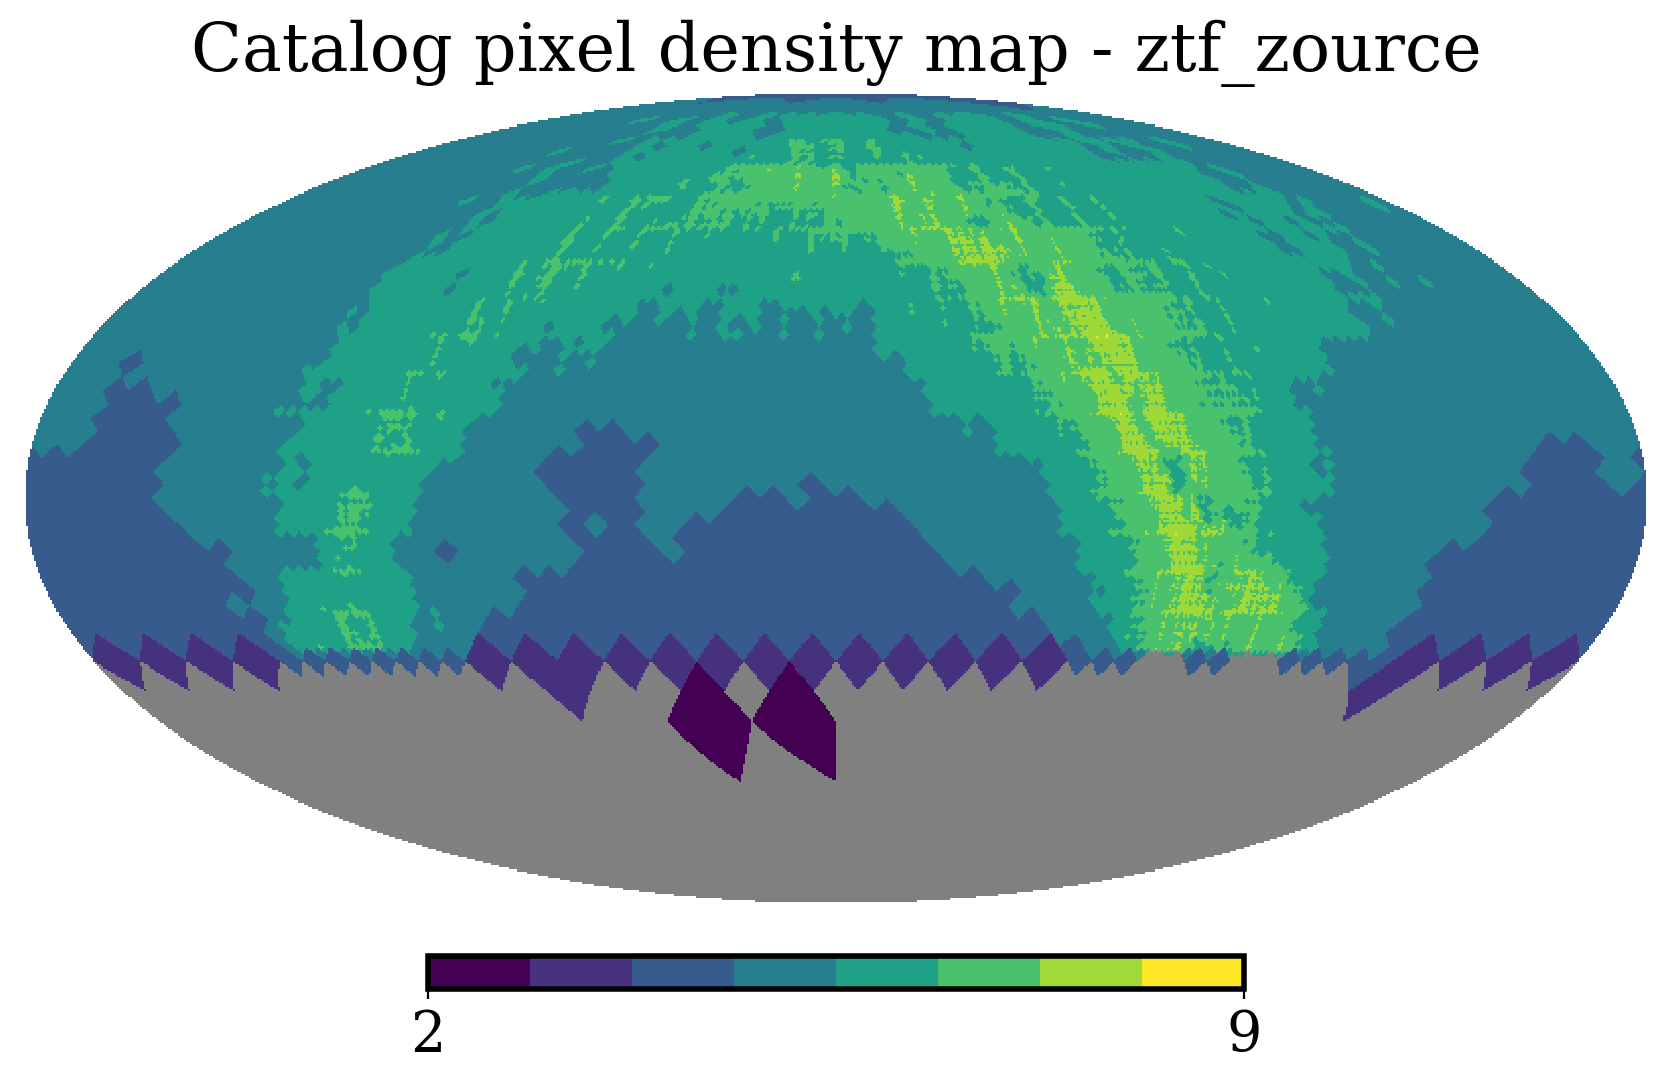

In [13]:
# Plot the Pixel Density Maps for Gaia and ZTF

#plot_pixels(gaia.hc_structure)
plot_pixels(ztf_object.hc_structure)
plot_pixels(ztf_source.hc_structure)

In [14]:
# Cross-match Gaia and ZTF
%time 
xmatch_object = gaia_lite.crossmatch(ztf_object)

xmatch_object.head(5)

CPU times: user 6 µs, sys: 4 µs, total: 10 µs
Wall time: 21 µs


/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


,ra_gaia,dec_gaia,ra_ztf_dr14,dec_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,
3645663899514044416,299.533159,18.211760,299.533154,18.211779,0.072382
3645663900969467904,299.530223,18.212685,299.530212,18.212697,0.056859
3645663901456007168,299.529506,18.212921,299.529480,18.212954,0.150216
3645663901607002112,299.531427,18.212798,299.531427,18.212937,0.502792
3645663901678305280,299.531440,18.212959,299.531427,18.212937,0.088326


In [15]:
%%time
# load ZTF with all columns here
ztf_object_full = lsdb.read_hipscat(ztf_object_path)

CPU times: user 302 ms, sys: 21.8 ms, total: 323 ms
Wall time: 339 ms


In [16]:
%%time
# crossmatch ZTF + Gaia
_all_sky_object = gaia.crossmatch(ztf_object_full).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5")

/epyc/users/ncaplar/anaconda3/envs/tape_static/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:121: RuntimeWarning: Right catalog does not have a margin cache. Results may be incomplete and/or inaccurate.
  warnings.warn(


CPU times: user 300 ms, sys: 3.64 ms, total: 304 ms
Wall time: 298 ms


In [17]:
%%time
total = _all_sky_object.compute()

CPU times: user 23.2 s, sys: 36.7 s, total: 59.9 s
Wall time: 7.72 s


In [18]:
total.head(5)

,solution_id_gaia,designation_gaia,source_id_gaia,random_index_gaia,ref_epoch_gaia,ra_gaia,ra_error_gaia,dec_gaia,dec_error_gaia,parallax_gaia,...,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
3646067079259357184,1636148068921376768,Gaia DR3 1823033542087957248,1823033542087957248,681413300,2016.0,300.344658,0.028663,19.554414,0.027776,0.668537,...,404,1009,0,16.879663,16.132171,<NA>,5,0,3238,0.077723
3646067849677504512,1636148068921376768,Gaia DR3 1823033920045097728,1823033920045097728,606871238,2016.0,300.426663,0.014488,19.587297,0.014479,0.972830,...,101,373,0,15.232552,14.680055,<NA>,5,0,3238,0.069844
3646068328969011200,1636148068921376768,Gaia DR3 1823034156246247424,1823034156246247424,987360779,2016.0,300.422159,0.042693,19.608572,0.041722,0.350765,...,94,362,0,17.727001,16.956606,<NA>,5,0,3238,0.039680
3646079368708489216,1636148068921376768,Gaia DR3 1823039658126194176,1823039658126194176,1633982299,2016.0,300.549673,0.041812,19.653736,0.039993,0.485155,...,352,953,0,17.264943,16.503687,<NA>,5,0,3238,0.067978
3646079377201954816,1636148068921376768,Gaia DR3 1823039692480622976,1823039692480622976,367753372,2016.0,300.531500,0.037491,19.641191,0.035262,0.380807,...,396,1008,0,17.493767,16.728938,<NA>,5,0,3238,0.049519


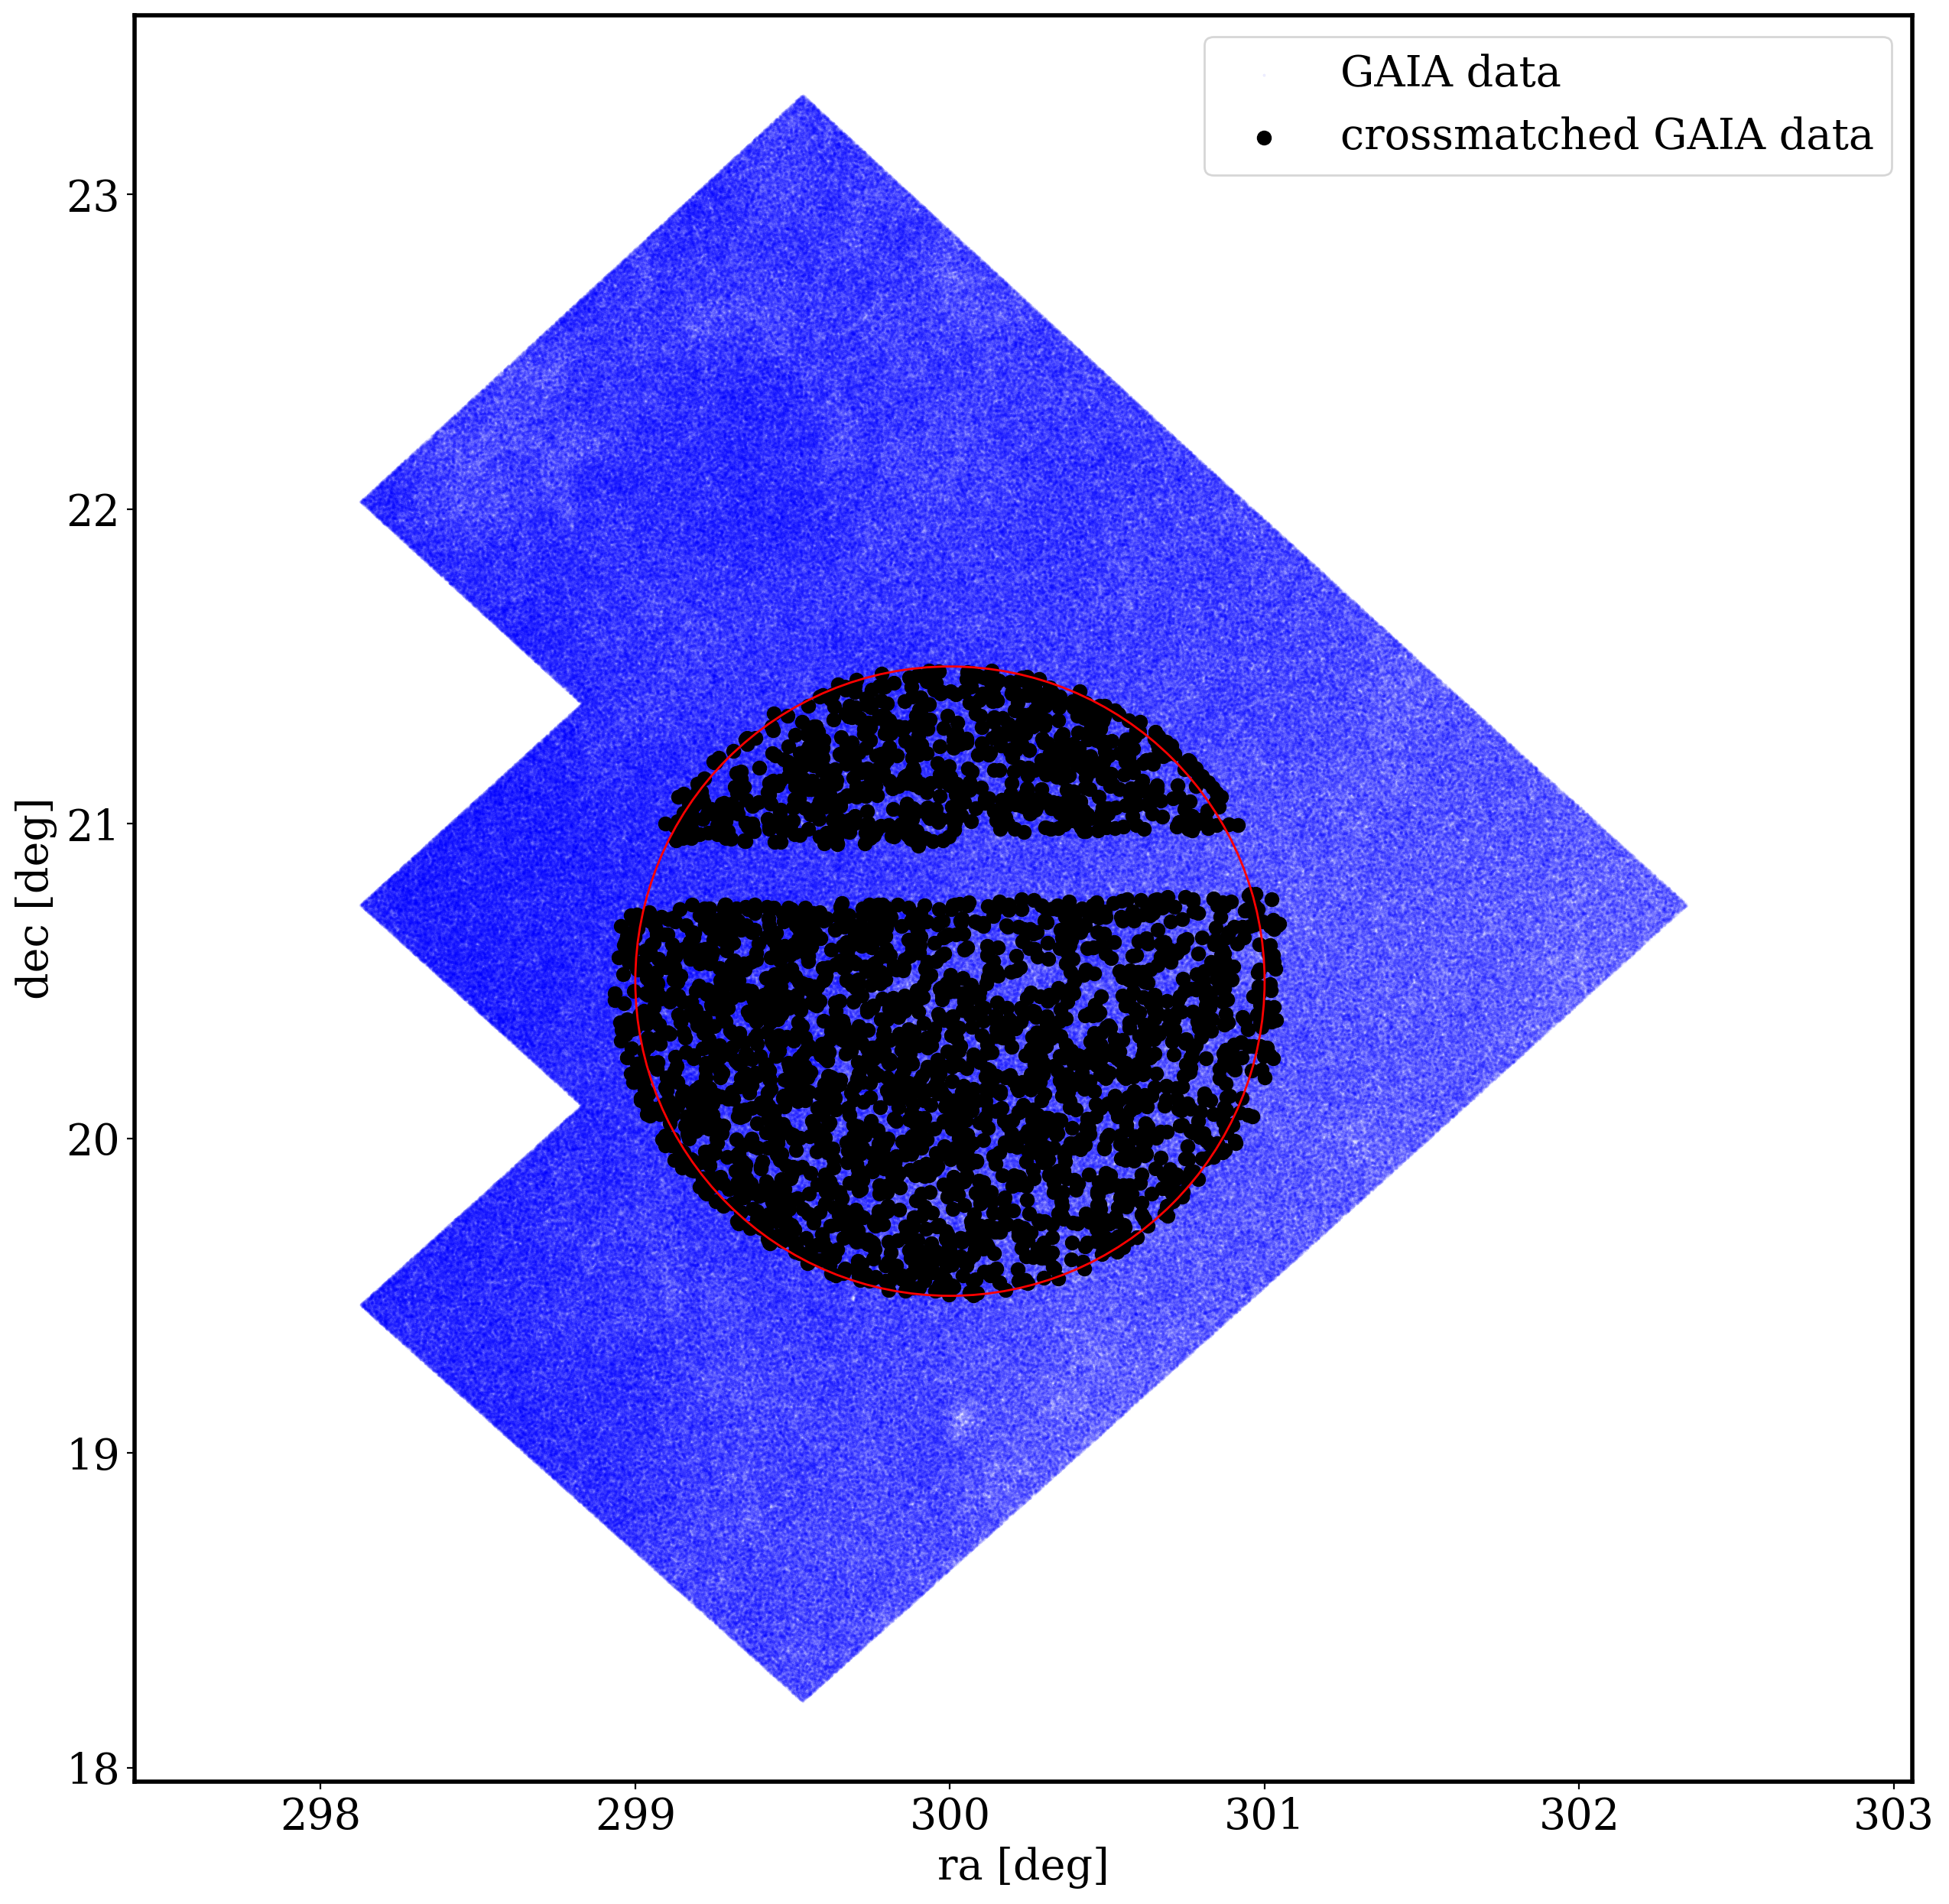

In [21]:
plt.figure(figsize=(15,15))

plt.scatter(gaia_lite_computed['ra'], gaia_lite_computed['dec'], color='blue', s=0.1, alpha=0.1, label='GAIA data')
plt.scatter(total['ra_gaia'].values, total['dec_gaia'].values, color='black', label='crossmatched GAIA data')
# Create a circle patch
circle = patches.Circle((300, 20.5), 1, edgecolor='red', facecolor='lightblue', fill=False)
plt.axis('equal')
# Use plt.gca() to get the current axes and add the circle to it
plt.gca().add_patch(circle)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')
plt.legend()

In [20]:
# export crossmatched data to disk
_all_sky_object.to_hipscat(base_catalog_path="ztf_x_gaia", catalog_name="ztf_x_gaia")